<a href="https://colab.research.google.com/github/idanhasdai/Final-Projcet/blob/main/Idan_Hasdai_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Embedding, Conv1D, Flatten, BatchNormalization, Bidirectional, GRU,SimpleRNN,GlobalAveragePooling1D,Reshape,Lambda
from tensorflow.keras.losses import huber
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Step 1: Load stock data
stock_data = yf.download('MSFT', start = "2018-03-02", end = "2020-07-18")
stock_data.reset_index(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data.set_index(keys = 'Date', inplace = True)
stock_data.head(1)

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2018-03-02,86.443398,86.536296,84.408887,85.077767,32830400


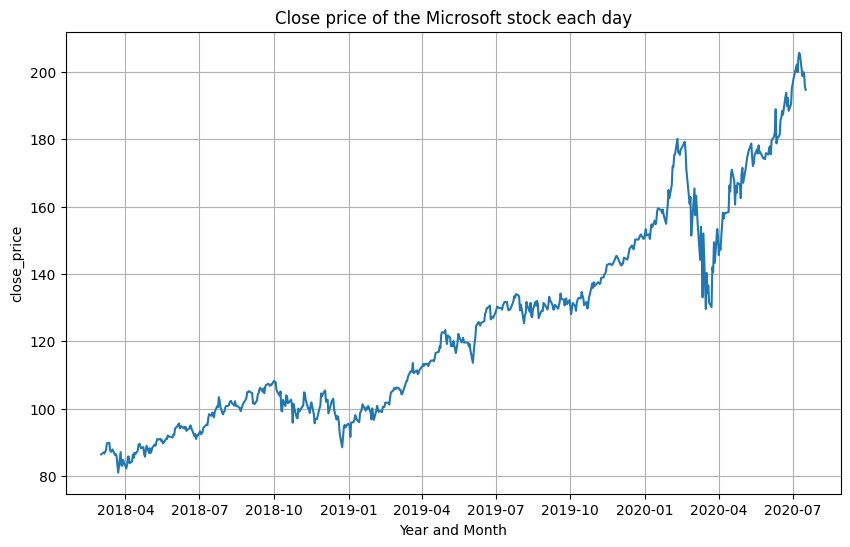

In [4]:
#plotting the close price by date
plt.figure(figsize = (10,6))
plt.plot(stock_data.index, stock_data["Close"])
plt.title('Close price of the Microsoft stock each day')
plt.grid(True)
plt.xlabel('Year and Month')
plt.ylabel('close_price')
plt.show()

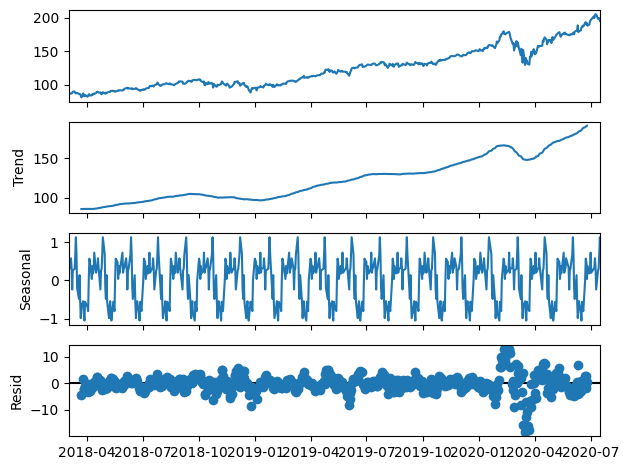

In [5]:
#looking at the seasonal decompose for roughly about a month
result = seasonal_decompose(stock_data['Close'],model = 'additive',period = 31) #period of 31 days
result.plot()
plt.show()

In [6]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2018-03-02,86.443398,86.536296,84.408887,85.077767,32830400
2018-03-05,86.991486,87.576753,85.709469,85.783784,23901600
2018-03-06,86.694221,87.781149,86.341204,87.641798,22175800
2018-03-07,87.195877,87.270199,85.867408,86.545580,26716100
2018-03-08,87.725433,88.347861,87.112290,87.576790,25887800


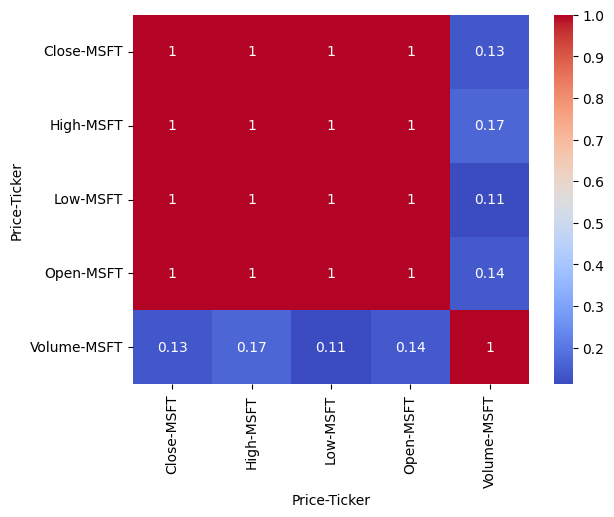

In [8]:
#checking for correlation between columns
sns.heatmap(stock_data.corr(),annot = True,cmap = 'coolwarm')
plt.show()

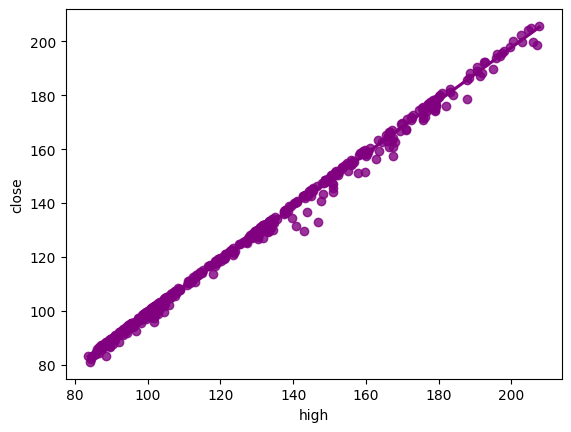

In [9]:
sns.regplot(x = 'High', y = 'Close', data = stock_data,color = 'Purple')
plt.xlabel('high')
plt.ylabel('close')
plt.show()

In [10]:
mask = stock_data[stock_data.index.is_quarter_start]

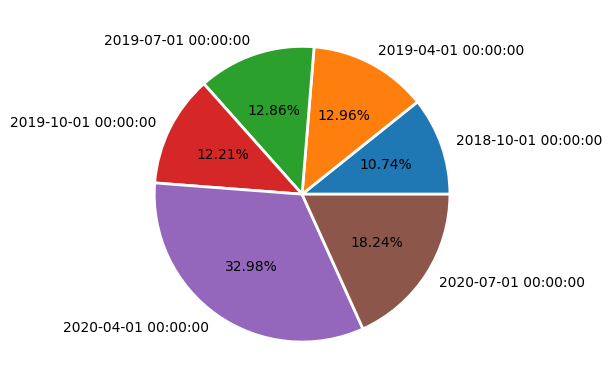

In [11]:
plt.pie(mask['Volume'].squeeze(),
       labels = mask['Volume'].index,
       wedgeprops = {'edgecolor':'white','linewidth':2},
       autopct = '%1.2f%%',
       )
plt.show()

In [12]:
 #loading the financial news
 !unzip fnews.zip -d fnews
 print('-'*20+'\n Upload Completed!!\n'+'-'*20)

Archive:  fnews.zip
  inflating: fnews/cnbc_headlines.csv  
  inflating: fnews/guardian_headlines.csv  
  inflating: fnews/reuters_headlines.csv  
--------------------
 Upload Completed!!
--------------------


In [13]:
#choosing the financial news dataset
reuters = pd.read_csv('fnews/reuters_headlines.csv')

In [14]:
reuters.head(3)

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...


In [15]:
reuters['Description'][0]

'TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership.'

In [174]:
#making a loop to see insights about the news
sentences = [len(i) for i in reuters['Headlines']]

In [175]:
#minimum length of headlines
min_len = np.min(sentences)
min_len

np.int64(20)

In [176]:
#maximum length of headlines
max_len = np.max(sentences)
max_len

np.int64(117)

In [177]:
#average length of headlines
mean_len = np.mean(sentences)
mean_len

np.float64(65.2905706438816)

In [20]:
reuters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


In [21]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 599 entries, 2018-03-02 to 2020-07-17
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, MSFT)   599 non-null    float64
 1   (High, MSFT)    599 non-null    float64
 2   (Low, MSFT)     599 non-null    float64
 3   (Open, MSFT)    599 non-null    float64
 4   (Volume, MSFT)  599 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 28.1 KB


In [22]:
#checking the columns names
stock_data.columns

MultiIndex([( 'Close', 'MSFT'),
            (  'High', 'MSFT'),
            (   'Low', 'MSFT'),
            (  'Open', 'MSFT'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])

In [23]:
#simplifying them
stock_data.columns = [col[0] for col in stock_data.columns]

In [24]:
#making sure it worked
stock_data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [25]:
#calculating the daily change
stock_data["Change"] = (stock_data["Close"].shift(-1)- stock_data["Close"])

In [26]:
# stock_data.set_index(keys = 'Date', inplace = True)
# stock_data.head(1)

In [27]:
pd.concat([stock_data["Close"],
           stock_data["Close"].shift(-1),
           stock_data["Close"].shift(+1)],
          keys = ["Close","tmw", "yesteday"], axis =1).head()

,Close,tmw,yesteday
Date,,,
2018-03-02,86.443398,86.991486,NaN
2018-03-05,86.991486,86.694221,86.443398
2018-03-06,86.694221,87.195877,86.991486
2018-03-07,87.195877,87.725433,86.694221
2018-03-08,87.725433,89.685600,87.195877


In [28]:
stock_data.head(1)

,Close,High,Low,Open,Volume,Change
Date,,,,,,
2018-03-02,86.443398,86.536296,84.408887,85.077767,32830400,0.548088


In [29]:
#making a column that presents the change the nexr day by one number
stock_data["label"] =0 #default - no change
stock_data.loc[stock_data["Change"] >0, "label"]= 1
stock_data.loc[stock_data["Change"] <0, "label"]= -1

In [30]:
stock_data[stock_data['label']==0]

,Close,High,Low,Open,Volume,Change,label
Date,,,,,,,
2018-06-18,94.104980,94.338237,92.761421,93.311910,23586000,0.0,0
2019-07-12,131.701813,131.919904,130.857936,131.654415,18936800,0.0,0
2019-12-20,150.259094,151.290033,149.189964,150.201822,53477500,0.0,0
2020-07-17,194.733231,196.806483,193.303057,196.259380,31635300,NaN,0


In [31]:
stock_data = stock_data.dropna()

In [32]:
stock_data.isna().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0
Change,0
label,0


In [33]:
stock_data.head(3)

,Close,High,Low,Open,Volume,Change,label
Date,,,,,,,
2018-03-02,86.443398,86.536296,84.408887,85.077767,32830400,0.548088,1
2018-03-05,86.991486,87.576753,85.709469,85.783784,23901600,-0.297264,-1
2018-03-06,86.694221,87.781149,86.341204,87.641798,22175800,0.501656,1


In [34]:
reuters.tail(3)

,Headlines,Time,Description
32767,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...
32768,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...
32769,UK will always consider ways to improve data l...,Mar 20 2018,Britain will consider any suggestions to give ...


In [35]:
#changing the name of the time column to date so it fits my other data
reuters.rename(columns = {'Time':'Date'},inplace = True)

In [36]:
reuters.isna().sum()

,0
Headlines,0
Date,0
Description,0


In [37]:
#making it a pd date time variable
reuters['Date'] = pd.to_datetime(reuters['Date'])

In [38]:
#setting the date as the index
reuters.set_index(keys = 'Date', inplace = True)
reuters.head(1)

,Headlines,Description
Date,,
2020-07-18,TikTok considers London and other locations fo...,TikTok has been in discussions with the UK gov...


In [39]:
reuters.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32770 entries, 2020-07-18 to 2018-03-20
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Description  32770 non-null  object
dtypes: object(2)
memory usage: 768.0+ KB


In [40]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 598 entries, 2018-03-02 to 2020-07-16
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   598 non-null    float64
 1   High    598 non-null    float64
 2   Low     598 non-null    float64
 3   Open    598 non-null    float64
 4   Volume  598 non-null    int64  
 5   Change  598 non-null    float64
 6   label   598 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 37.4 KB


In [41]:
reuters.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32770 entries, 2020-07-18 to 2018-03-20
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Description  32770 non-null  object
dtypes: object(2)
memory usage: 768.0+ KB


In [42]:
stock_data[stock_data.isnull().any(axis = 1)]

,Close,High,Low,Open,Volume,Change,label
Date,,,,,,,


In [43]:
stock_data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0
Change,0
label,0


--------CLASSIC MODELS----------

In [44]:
#defining feature and target
X = stock_data.drop(columns = ['Change','label'], axis = 1) #feature
y = stock_data['label'] #target

#spliting it to 80% train 20% test
split_time = int(len(X)*0.8)

#splitting to train and test
X_train,X_test = X[:split_time], X[split_time:]
y_train,y_test = y[:split_time], y[split_time:]

In [45]:
#standard sacling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [46]:
X.shape

(598, 5)

In [47]:
#building my machine learning models
svm_model = svm.SVC(C = 1,
                    kernel = 'linear',
                    gamma = 'scale',
                    shrinking = True)

rf_model = RandomForestClassifier(min_samples_split = 5,
                                  n_estimators = 200,
                                  max_depth = 5,
                                  max_features = 'sqrt')

lr_model = LogisticRegression(C = 10,
                              max_iter = 100,
                              solver = 'liblinear')

In [48]:
#training the model
svm_model.fit(X_train_scaled,y_train)

SVC(C=1, kernel='linear')

In [49]:
#training the model
rf_model.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=200)

In [50]:
#training the model
lr_model.fit(X_train_scaled,y_train)

LogisticRegression(C=10, solver='liblinear')

In [51]:
#making a prediction
svm_pred = svm_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_scaled)
lr_pred = lr_model.predict(X_test_scaled)

In [52]:
rf_pred.shape

(120,)

In [53]:
#making a prediction for the test to check for overfitting
lr_train_pred = lr_model.predict(X_train_scaled)
rf_train_pred = rf_model.predict(X_train_scaled)
svm_train_pred = svm_model.predict(X_train_scaled)

In [54]:
lr_train_accuracy = accuracy_score(y_train,lr_train_pred)
rf_train_accuracy = accuracy_score(y_train,rf_train_pred)
svm_train_accuracy = accuracy_score(y_train,svm_train_pred)
print(f'the logistic regression train accuracy is: {lr_train_accuracy}')
print(f'the random forest classifier train accuracy is: {rf_train_accuracy}')
print(f'the svm train accuracy is: {svm_train_accuracy}')

the logistic regression train accuracy is: 0.5753138075313807
the random forest classifier train accuracy is: 0.7384937238493724
the svm train accuracy is: 0.5690376569037657


In [55]:
svm_accuracy = accuracy_score(y_test,svm_pred)
rf_accuracy = accuracy_score(y_test,rf_pred)
lr_accuracy = accuracy_score(y_test,lr_pred)

print(f'the logistic regression accuracy score is: {lr_accuracy}')
print(f'the random forest classifier accuracy score is: {rf_accuracy}')
print(f'the svm accuracy score is: {svm_accuracy}')

the logistic regression accuracy score is: 0.625
the random forest classifier accuracy score is: 0.5666666666666667
the svm accuracy score is: 0.5833333333333334


In [56]:
#defining classification reports for each model
svm_classification = classification_report(y_test,svm_pred)
lr_classification = classification_report(y_test,lr_pred)
rf_classification = classification_report(y_test,rf_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
print(svm_classification)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        50
           1       0.58      1.00      0.74        70

    accuracy                           0.58       120
   macro avg       0.29      0.50      0.37       120
weighted avg       0.34      0.58      0.43       120



In [58]:
print(lr_classification)

              precision    recall  f1-score   support

          -1       0.62      0.26      0.37        50
           1       0.63      0.89      0.73        70

    accuracy                           0.62       120
   macro avg       0.62      0.57      0.55       120
weighted avg       0.62      0.62      0.58       120



In [59]:
print(rf_classification)

              precision    recall  f1-score   support

          -1       0.43      0.12      0.19        50
           1       0.58      0.89      0.70        70

    accuracy                           0.57       120
   macro avg       0.51      0.50      0.45       120
weighted avg       0.52      0.57      0.49       120



In [60]:
#defining confusion matrix for each model
svm_confusion_matrix = confusion_matrix(y_test,svm_pred)
lr_confusion_matrix = confusion_matrix(y_test,lr_pred)
rf_confusion_matrix = confusion_matrix(y_test,rf_pred)

In [61]:
classes = np.unique(y_test)

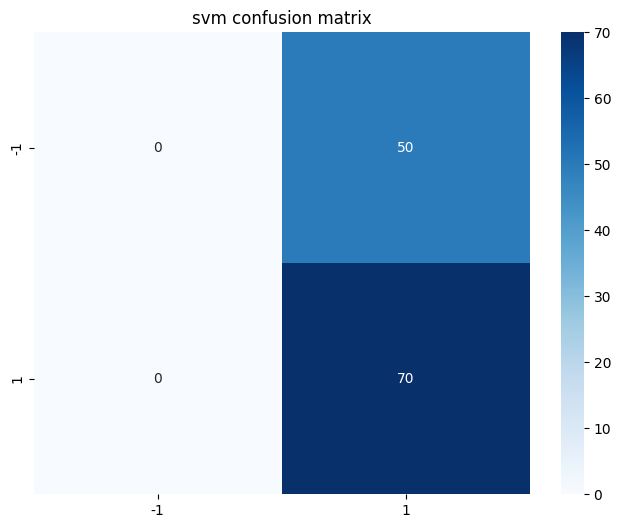

In [62]:
plt.figure(figsize = (8,6))
sns.heatmap(svm_confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title('svm confusion matrix')
plt.show()

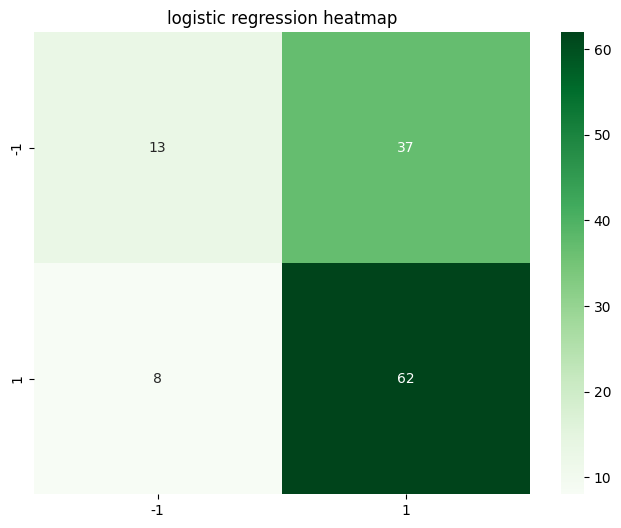

In [63]:
plt.figure(figsize = (8,6))
sns.heatmap(lr_confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Greens',
            xticklabels = classes,
            yticklabels = classes)
plt.title('logistic regression heatmap')
plt.show()

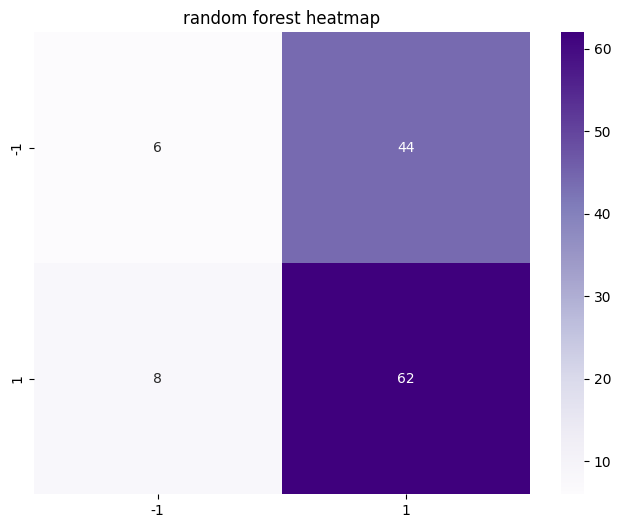

In [173]:
plt.figure(figsize = (8,6))
sns.heatmap(rf_confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Purples',
            xticklabels = classes,
            yticklabels = classes)
plt.title('random forest heatmap')
plt.show()

**LSTM**

In [65]:
#defining a window function
def create_windows(series,window_size):
  X_seq,y_seq = [],[]
  for i in range(len(series)-window_size):
    X_seq.append(series[i:window_size+i])
    y_seq.append(series[window_size+i])
  return np.array(X_seq), np.array(y_seq)

In [66]:
#choosing windows, feature and target
window_size = 90
X_seq,y_seq = create_windows(stock_data['Close'],window_size)

<ipython-input-65-2f3e25fe9e8d>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(series[window_size+i])


In [67]:
#splitting the data
split_time = int(len(X_seq)*0.8)
X_train_lstm,X_valid = X_seq[:split_time], X_seq[split_time:]

y_train_lstm,y_valid = y_seq[:split_time], y_seq[split_time:]

In [68]:
print(X_train_lstm.shape)  # Should be (num_samples, timesteps, features)
print(X_valid.shape)  # Should be (num_samples, timesteps, features)
print(y_train_lstm.shape)   # Should be (num_samples,)
print(y_valid.shape)

(406, 90)
(102, 90)
(406,)
(102,)


In [69]:
# callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - loss: 95.0806 - mae: 95.0806 - val_loss: 77.2223 - val_mae: 77.2223 - learning_rate: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 20.9312 - mae: 20.9312 - val_loss: 49.0808 - val_mae: 49.0808 - learning_rate: 0.0050
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 17.3537 - mae: 17.3537 - val_loss: 36.2307 - val_mae: 36.2307 - learning_rate: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 13.7121 - mae: 13.7121 - val_loss: 34.7667 - val_mae: 34.7667 - learning_rate: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 7.6814 - mae: 7.6814 - val_loss: 16.8570 - val_mae: 16.8570 - learning_rate: 0.0050
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - loss: 10.1238 - mae: 10.1238 - val_loss: 14.4336 - val_mae: 14.4336 - learning_rate: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 6.4200 - mae: 6.4200 - val_loss: 11.5491 - val_mae: 11.5491

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


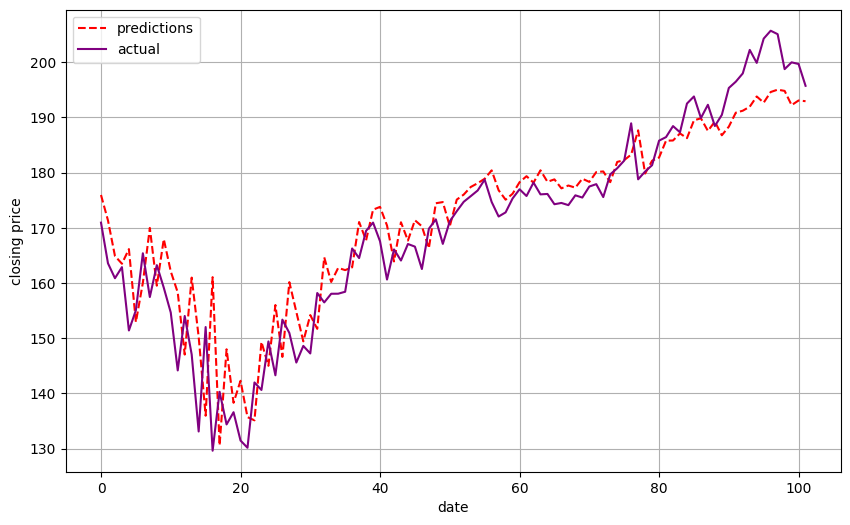

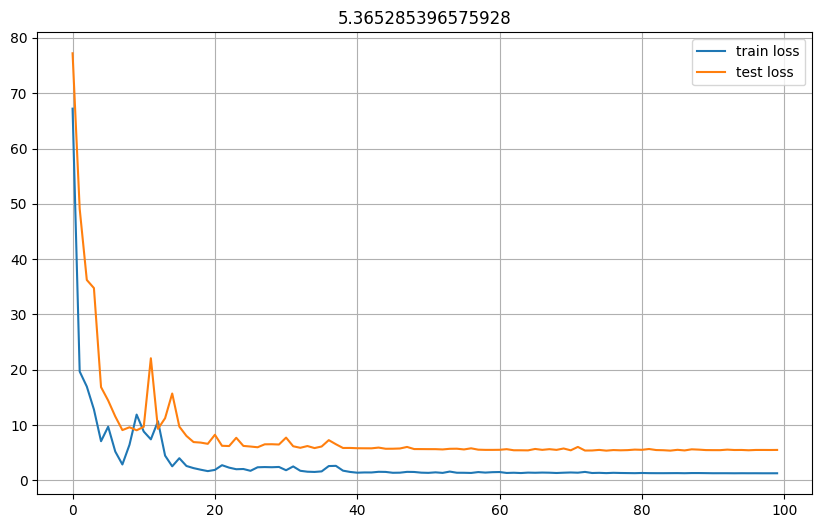

In [178]:
#building my deep learning model
model = tf.keras.models.Sequential([
    Input(shape=(window_size,1)),
    LSTM(128),
    tf.keras.layers.Dense(256,activation = 'relu'),
    tf.keras.layers.Dense(128,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(16,activation = 'relu'),
    tf.keras.layers.Dense(1)
])

#compiling the model
model.compile(
    loss = 'mae',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
    metrics = ['mae']
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 5,
    verbose = 1,
    min_lr = 1e-6
)

#training the model
history = model.fit(
    X_train_lstm,y_train_lstm,
    validation_data = (X_valid,y_valid),
    epochs = 100,
    batch_size = 32,
    callbacks = [lr_scheduler]
)

#making a prediction
y_pred_lstm = model.predict(X_valid)
y_pred_lstm = np.squeeze(y_pred_lstm, axis=-1)
time_valid = stock_data.index[window_size:]

#plotting the results
plt.figure(figsize = (10,6))
plt.plot(y_pred_lstm,
         label = 'predictions',
         linestyle = 'dashed',
         color = 'red')
plt.plot(y_valid,
         label = 'actual',
         color = 'purple')
plt.xlabel('date')
plt.ylabel('closing price')
plt.grid(True)
plt.legend()
plt.show()

#plotting the loss and val_loss
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'],label = 'train loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.title(min(history.history['val_loss']))
plt.grid(True)
plt.legend()
plt.show()

**NLP**

In [72]:
#definind a tokenizer to vectorize all the words in the financial news dataset
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(reuters['Headlines']) #tokenizing the headlines column
sequences = tokenizer.texts_to_sequences(reuters['Headlines']) #converting to a list of integers
word_index = tokenizer.word_index
padded = pad_sequences(sequences,maxlen = 500,padding = 'post', truncating = 'post') #making sure all sequences have the same length

In [74]:
X_NLP = padded

In [140]:
#building a model to get a sentiment
NLP_model = Sequential([
    Embedding(input_dim = len(word_index)+1,output_dim = 128),
    Dense(32,activation = 'relu'),
    Dense(1)
])

NLP_pred = NLP_model.predict(padded)

1025/1025 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


In [141]:
NLP_pred

array([[[-0.01278014],
        [-0.02923386],
        [ 0.01257602],
        ...,
        [ 0.00612491],
        [ 0.0061249 ],
        [ 0.0061249 ]],

       [[-0.0163829 ],
        [ 0.0031348 ],
        [ 0.00967864],
        ...,
        [ 0.00612491],
        [ 0.0061249 ],
        [ 0.0061249 ]],

       [[-0.00542653],
        [ 0.0059969 ],
        [ 0.0253593 ],
        ...,
        [ 0.00612491],
        [ 0.0061249 ],
        [ 0.0061249 ]],

       ...,

       [[ 0.05230862],
        [-0.05235384],
        [ 0.02507653],
        ...,
        [ 0.00612491],
        [ 0.0061249 ],
        [ 0.0061249 ]],

       [[ 0.0178937 ],
        [ 0.00220454],
        [ 0.04000554],
        ...,
        [ 0.00612491],
        [ 0.0061249 ],
        [ 0.0061249 ]],

       [[ 0.02707744],
        [ 0.01418551],
        [-0.02038858],
        ...,
        [ 0.00612491],
        [ 0.0061249 ],
        [ 0.0061249 ]]], dtype=float32)

In [142]:
NLP_pred.shape

(32770, 500, 1)

In [145]:
#making a sentiment column
reuters['NLP_pred'] = NLP_pred.squeeze()

In [146]:
#making a new data frame of both the stock and the sentiment
news_data_grouped = reuters.groupby('Date')['NLP_pred'].sum()
merged_df = pd.merge(stock_data,news_data_grouped,on = 'Date', how = 'inner')

In [147]:
merged_df.tail()

,Close,High,Low,Open,Volume,Change,label,NLP_pred
Date,,,,,,,,
2020-07-10,205.089966,205.483506,202.603972,205.041971,26177600,-6.334930,-1,0.625539
2020-07-13,198.755035,207.134475,198.207917,205.867473,38135600,1.228592,1,0.446508
2020-07-14,199.983627,200.463550,193.917402,197.852771,37591800,-0.297562,-1,1.397259
2020-07-15,199.686066,202.843963,196.796939,201.145034,32179400,-3.954575,-1,0.854547
2020-07-16,195.731491,197.440013,194.186141,197.152057,29940700,-0.998260,-1,0.785219


In [148]:
merged_df.head()

,Close,High,Low,Open,Volume,Change,label,NLP_pred
Date,,,,,,,,
2018-03-20,86.517731,87.112290,86.396963,86.443416,23075200,-0.603882,-1,0.297750
2018-03-21,85.913849,87.372377,85.663015,86.331896,24457100,-2.498985,-1,0.185888
2018-03-22,83.414864,85.235702,83.294096,84.789779,38604700,-2.424698,-1,1.230271
2018-03-23,80.990166,84.037283,80.897267,83.145444,44068900,6.131386,1,0.806055
2018-03-26,87.121552,87.325932,83.981536,84.176625,56396800,-4.003998,-1,0.694857


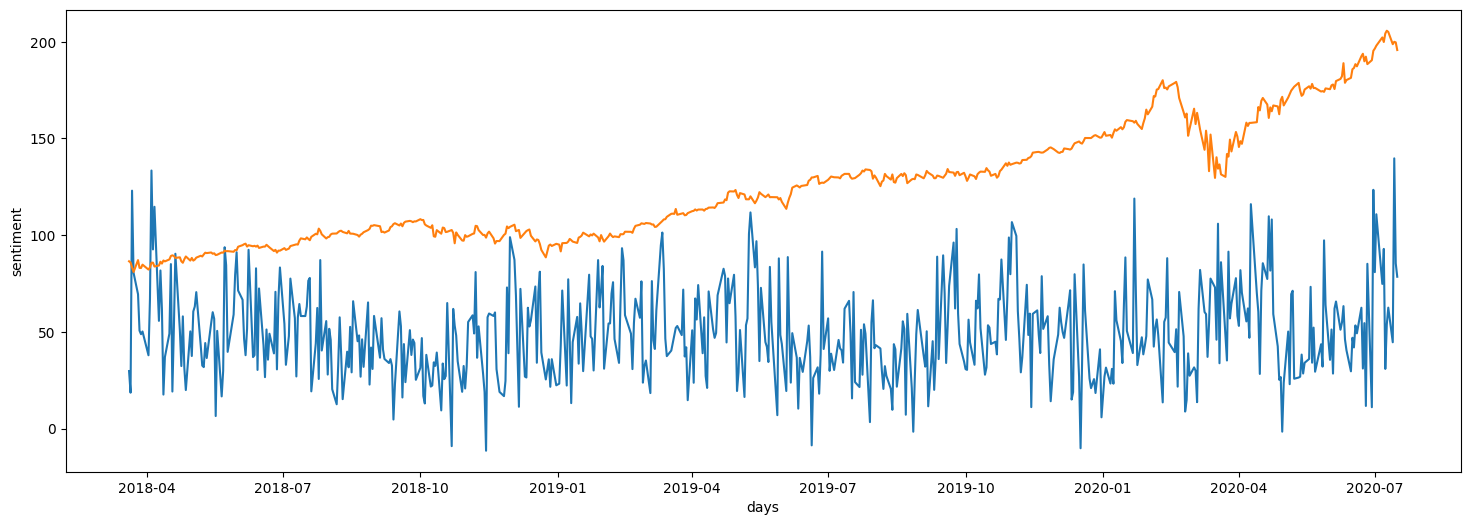

In [151]:
plt.figure(figsize = (18,6))
plt.plot(merged_df.index,merged_df['NLP_pred']*100)
plt.plot(merged_df['Close'])
plt.xlabel('days')
plt.ylabel('sentiment')
plt.show()

In [105]:
list(word_index.items())[:30]

[('<OOV>', 1),
 ('to', 2),
 ('s', 3),
 ('u', 4),
 ('in', 5),
 ('on', 6),
 ('for', 7),
 ('of', 8),
 ('as', 9),
 ('says', 10),
 ('china', 11),
 ('with', 12),
 ('trade', 13),
 ('billion', 14),
 ('after', 15),
 ('deal', 16),
 ('new', 17),
 ('ceo', 18),
 ('coronavirus', 19),
 ('over', 20),
 ('oil', 21),
 ('and', 22),
 ('at', 23),
 ('sources', 24),
 ('from', 25),
 ('trump', 26),
 ('up', 27),
 ('exclusive', 28),
 ('the', 29),
 ('by', 30)]

In [152]:
#defining another window function
def create_windows_nlp(series,window_size_nlp):
  X,y = [],[]
  for i in range(len(series)-window_size):
    X.append(series[i:i+window_size])
    y.append(series[i+window_size])
  return np.array(X), np.array(y)

#choosing window size
window_size_nlp = 90

#standard scaling
nlp_scaler = StandardScaler()
scaled = nlp_scaler.fit_transform(merged_df[['Close','NLP_pred']])

#choosing feature and target
nlp_X,nlp_y = create_windows_nlp(scaled,window_size_nlp)

#splitting the data
split_time_nlp = int(len(nlp_X)*0.8)

X_train_nlp, X_valid_nlp = nlp_X[:split_time_nlp], nlp_X[split_time_nlp:]
y_train_nlp, y_valid_nlp = nlp_y[:split_time_nlp], nlp_y[split_time_nlp:]

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 3.0270 - mae: 3.0270 - val_loss: 0.9893 - val_mae: 0.9893 - learning_rate: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.6795 - mae: 0.6795 - val_loss: 1.1090 - val_mae: 1.1090 - learning_rate: 0.0050
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.6517 - mae: 0.6517 - val_loss: 0.9895 - val_mae: 0.9895 - learning_rate: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.5806 - mae: 0.5806 - val_loss: 1.6587 - val_mae: 1.6587 - learning_rate: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.8062 - mae: 0.8062 - val_loss: 1.3340 - val_mae: 1.3340 - learning_rate: 0.0050
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.6188 - mae: 0.6188
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.6179 - mae: 0.6179 - val_loss: 1.6459 - val_mae: 1.6459 - learning_rate: 0.0

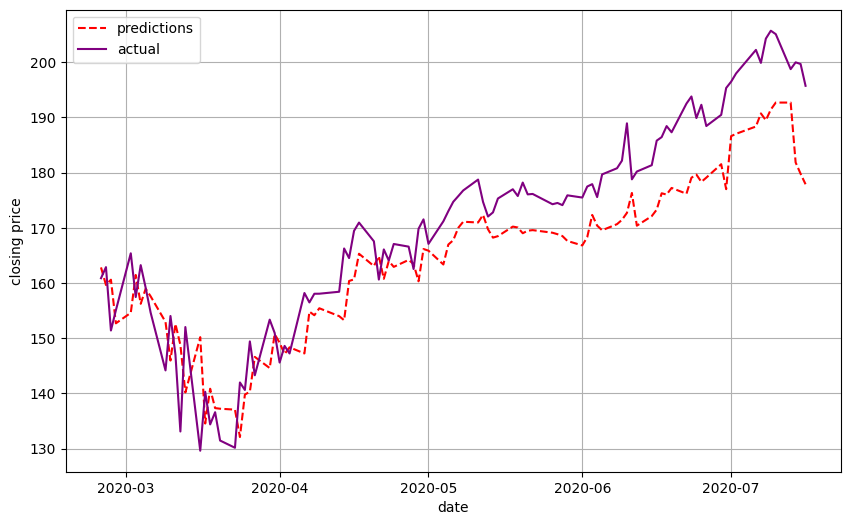

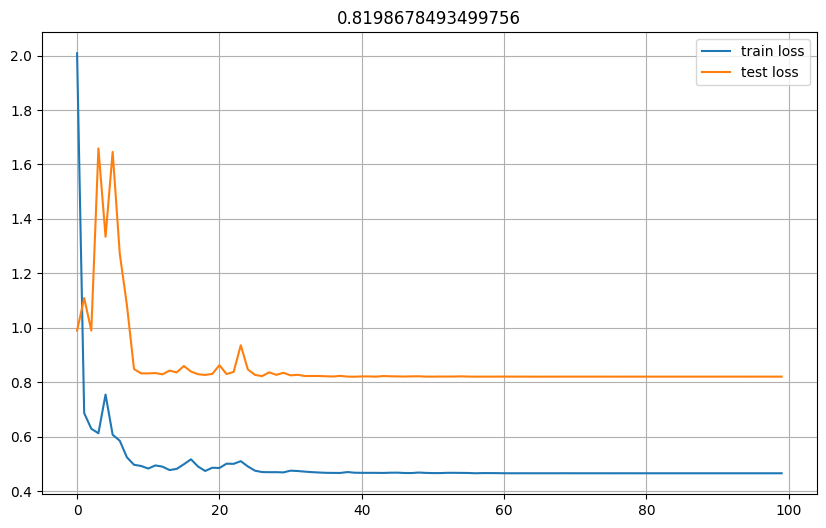

In [153]:
#building my deep learning model
sentiment_model = tf.keras.models.Sequential([
    Input(shape=(window_size_nlp,2)),
    LSTM(128),
    tf.keras.layers.Dense(256,activation = 'relu'),
    tf.keras.layers.Dense(128,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(16,activation = 'relu'),
    tf.keras.layers.Dense(1),
    Lambda(lambda x:x-5)
])

#compiling the model
sentiment_model.compile(
    loss = 'mae',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
    metrics = ['mae']
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 5,
    verbose = 1,
    min_lr = 1e-6
)

#training the model
sentiment_history = sentiment_model.fit(
    X_train_nlp,y_train_nlp,
    validation_data = (X_valid_nlp,y_valid_nlp),
    epochs = 100,
    batch_size = 32,
    callbacks = [lr_scheduler]
)

#making a prediction
y_pred_nlp = sentiment_model.predict(X_valid_nlp)
y_pred_nlp = nlp_scaler.inverse_transform(np.concatenate([y_pred_nlp,np.zeros_like(y_pred_nlp)],axis = 1))
y_pred_nlp_close = y_pred_nlp[:,0]
time_valid_nlp = merged_df.index[split_time_nlp:]

#plotting the prediction and the actual data
plt.figure(figsize = (10,6))
plt.plot(merged_df.index[split_time_nlp+window_size_nlp:],y_pred_nlp_close,
         label = 'predictions',
         linestyle = 'dashed',
         color = 'red')
plt.plot(merged_df.index[split_time_nlp+window_size_nlp:],merged_df['Close'][split_time_nlp+window_size_nlp:],
         label = 'actual',
         color = 'purple')
plt.xlabel('date')
plt.ylabel('closing price')
plt.grid(True)
plt.legend()
plt.show()

#plotting the loss and val_loss
plt.figure(figsize = (10,6))
plt.plot(sentiment_history.history['loss'],label = 'train loss')
plt.plot(sentiment_history.history['val_loss'], label = 'test loss')
plt.title(min(sentiment_history.history['val_loss'])) # Changed sentimrnt_history to sentiment_history
plt.grid(True)
plt.legend()
plt.show()

In [154]:
#building machine learning models
svm_model_nlp = svm.SVC(C = 1,
                    kernel = 'linear',
                    gamma = 'scale',
                    shrinking = True)

rf_model_nlp = RandomForestClassifier(min_samples_split = 5,
                                  n_estimators = 200,
                                  max_depth = 5,
                                  max_features = 'sqrt')

lr_model_nlp = LogisticRegression(C = 10,
                              max_iter = 100,
                              solver = 'liblinear')

In [155]:
#flattening the features
X_train_nlp_flat = X_train_nlp.reshape(X_train_nlp.shape[0], -1)
#converting the target to one integer
y_train_nlp_ml = np.argmax(y_train_nlp, axis=1)

In [156]:
lr_model_nlp.fit(X_train_nlp_flat, y_train_nlp_ml)

LogisticRegression(C=10, solver='liblinear')

In [157]:
svm_model_nlp.fit(X_train_nlp_flat,y_train_nlp_ml)

SVC(C=1, kernel='linear')

In [158]:
rf_model_nlp.fit(X_train_nlp_flat,y_train_nlp_ml)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=200)

In [159]:
#flattening the features
X_valid_nlp_flat = X_valid_nlp.reshape(X_valid_nlp.shape[0], -1)
#converting the target to one integer
y_valid_nlp_ml = np.argmax(y_valid_nlp, axis=1)

In [160]:
#predicting the accuracy score
lr_nlp_pred = lr_model_nlp.predict(X_valid_nlp_flat)
rf_nlp_pred = rf_model_nlp.predict(X_valid_nlp_flat)
svm_nlp_pred = svm_model_nlp.predict(X_valid_nlp_flat)

lr_nlp_acc = accuracy_score(y_valid_nlp_ml,lr_nlp_pred)
rf_nlp_acc = accuracy_score(y_valid_nlp_ml,rf_nlp_pred)
svm_nlp_acc = accuracy_score(y_valid_nlp_ml,svm_nlp_pred)

print(f'logistic regression accuracy is: {lr_nlp_acc}')
print(f'random forest accuracy is: {rf_nlp_acc}')
print(f'svm accuracy is: {svm_nlp_acc}')

logistic regression accuracy is: 0.83
random forest accuracy is: 0.83
svm accuracy is: 0.83


In [161]:
#predicting the accuracy score of the train data
lr_nlp_train_pred = lr_model_nlp.predict(X_train_nlp_flat)
rf_nlp_train_pred = rf_model_nlp.predict(X_train_nlp_flat)
svm_nlp_train_pred = svm_model_nlp.predict(X_train_nlp_flat)

lr_nlp_train_acc = accuracy_score(y_train_nlp_ml,lr_nlp_train_pred)
rf_nlp_train_acc = accuracy_score(y_train_nlp_ml,rf_nlp_train_pred)
svm_nlp_train_acc = accuracy_score(y_train_nlp_ml,svm_nlp_train_pred)

print(f'logistic regression accuracy is: {lr_nlp_train_acc}')
print(f'random forest accuracy is: {rf_nlp_train_acc}')
print(f'svm accuracy is: {svm_nlp_train_acc}')

logistic regression accuracy is: 0.8813131313131313
random forest accuracy is: 0.8762626262626263
svm accuracy is: 0.8762626262626263


In [164]:
rf_classification_report = classification_report(y_valid_nlp_ml, rf_nlp_pred)
print(rf_classification_report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        83
           1       0.00      0.00      0.00        17

    accuracy                           0.83       100
   macro avg       0.41      0.50      0.45       100
weighted avg       0.69      0.83      0.75       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [165]:
svm_classification_report = classification_report(y_valid_nlp_ml, svm_nlp_pred)
print(svm_classification_report)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91        83
           1       0.50      0.06      0.11        17

    accuracy                           0.83       100
   macro avg       0.67      0.52      0.51       100
weighted avg       0.78      0.83      0.77       100



In [166]:
lr_classification_report = classification_report(y_valid_nlp_ml, lr_nlp_pred)
print(lr_classification_report)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        83
           1       0.50      0.24      0.32        17

    accuracy                           0.83       100
   macro avg       0.68      0.59      0.61       100
weighted avg       0.80      0.83      0.80       100



In [167]:
#defining confusion matrixes
svm_confusion_matrix_nlp = confusion_matrix(y_valid_nlp_ml,svm_nlp_pred)
lr_confusion_matrix_nlp = confusion_matrix(y_valid_nlp_ml,lr_nlp_pred)
rf_confusion_matrix_nlp = confusion_matrix(y_valid_nlp_ml,rf_nlp_pred)

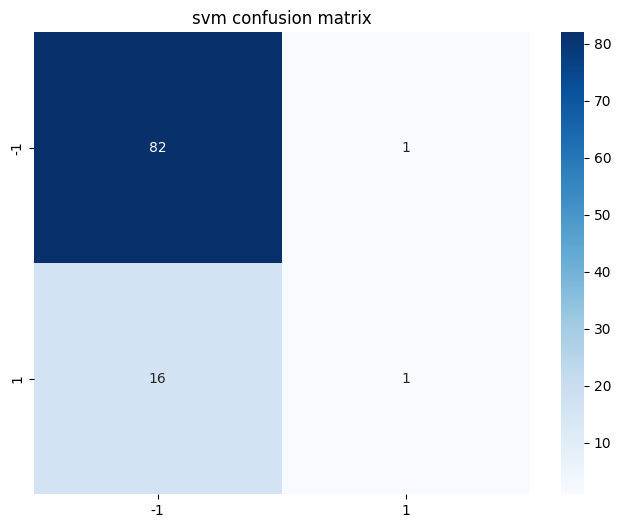

In [168]:
#plotting the confusion matrix of the svm model
plt.figure(figsize = (8,6))
sns.heatmap(svm_confusion_matrix_nlp,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title('svm confusion matrix')
plt.show()

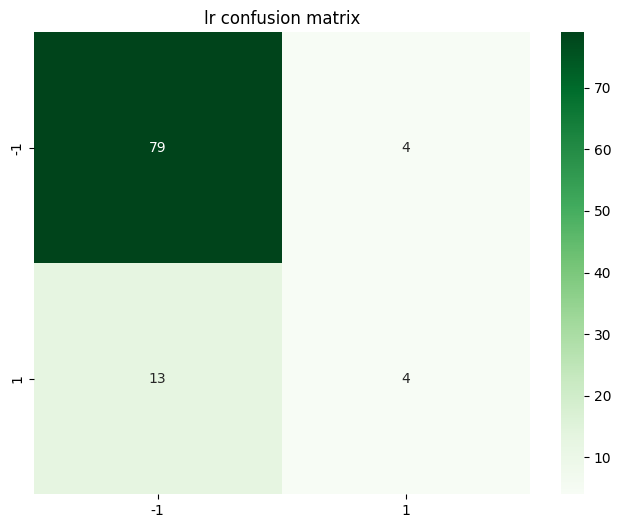

In [171]:
#plotting the confusion matrix of the logistic regression model
plt.figure(figsize = (8,6))
sns.heatmap(lr_confusion_matrix_nlp,
            annot = True,
            fmt = 'd',
            cmap = 'Greens',
            xticklabels=classes,
            yticklabels=classes)
plt.title('lr confusion matrix')
plt.show()

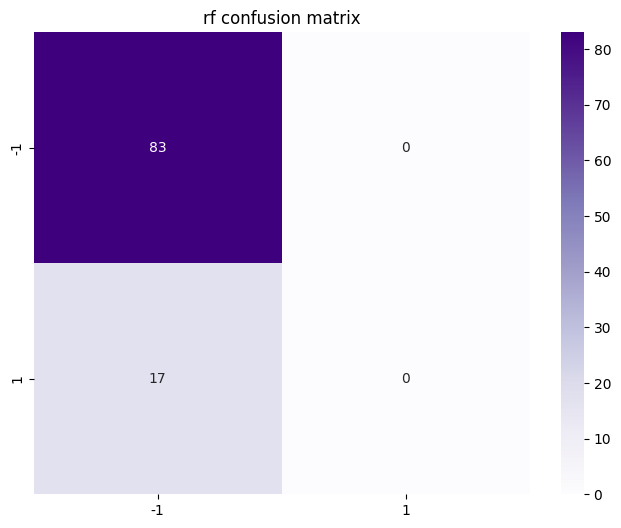

In [172]:
#plotting the confusion matrix of the random forest model
plt.figure(figsize = (8,6))
sns.heatmap(rf_confusion_matrix_nlp,
            annot = True,
            fmt = 'd',
            cmap = 'Purples',
            xticklabels=classes,
            yticklabels=classes)
plt.title('rf confusion matrix')
plt.show()